# Nutrition dataset case study

In [1]:
# limit the number of threads used by xgboost models
import os
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["OPENBLAS_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["VECLIB_MAXIMUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"

# standard libaries
import sys
import copy
import dill
from collections import defaultdict
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# flow specific packages
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import ParallelCreditFlow, GraphExplainer, translator
from flow import group_nodes, build_feature_graph
from flow import CausalLinks, create_xgboost_f
from flow import edge_credits2edge_credit
from on_manifold import OnManifoldExplainer, IndExplainer

np.random.seed(42) # fix for reproducibility

# Dataset

In [2]:
X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values
# remove the first column: unnamed: 0
X = X.iloc[:, 1:]
X_display = X_display.iloc[:, 1:]

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

print(X.shape, X_display.shape)
X.head()

(9932, 18) (9932, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0


# Explanation settings

In [3]:
n_bg = 1 # paper: 100, number of sampled background samples
nsamples = 100 # number of fg samples to explain
nruns = 100 # paper: 10,000, number of monte carlo samplings
bg = X.fillna(X.mean()).sample(n_bg) # background samples
fg = X[:nsamples] # foreground samples to explain
sample_ind = 55 # sample to show

# Training

In [4]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=100)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model_train

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-cox-nloglik:7.26934
[100]	test-cox-nloglik:7.04554
[200]	test-cox-nloglik:6.90625
[300]	test-cox-nloglik:6.80909
[400]	test-cox-nloglik:6.73926
[500]	test-cox-nloglik:6.68686
[600]	test-cox-nloglik:6.64699
[700]	test-cox-nloglik:6.61571
[800]	test-cox-nloglik:6.59138
[900]	test-cox-nloglik:6.57148
[999]	test-cox-nloglik:6.55579


In [5]:
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 1000, evals = [(xgb_full, "test")], verbose_eval=1000)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-cox-nloglik:8.88081
[999]	test-cox-nloglik:8.16748


In [6]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test, ntree_limit=5000), y_test)

0.8289463410825477

# Ind Shap

0it [00:00, ?it/s]


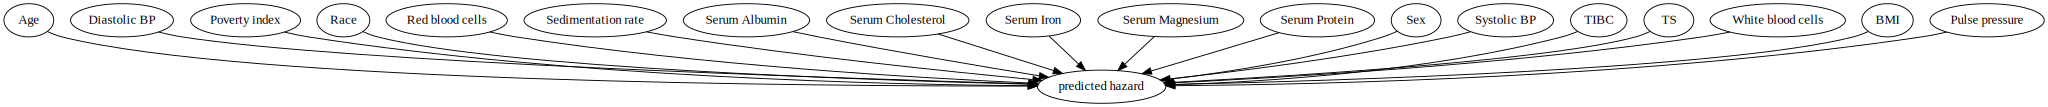

In [7]:
causal_links = CausalLinks()
categorical_feature_names = ['Race', 'Sex']
display_translator = translator(X.columns, X, X_display)
target_name = 'predicted hazard'
feature_names = list(X.columns)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_xgboost_f(feature_names, model, output_margin=True)) # the target
graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name)
graph.draw()

In [8]:
def node_dict2str_dict(node_edge_credit):
    res = defaultdict(lambda: defaultdict(int))
    for node1, d in node_edge_credit.items():
        for node2, val in d.items():
            res[node1.name][node2.name] = val
    return res

# multiple background result with individual run
edge_credits = [] # save for each run
for i in range(len(bg)): # average run result using linearity axiom
    print(f'bg {i}/{len(bg)}')
    explainer = GraphExplainer(graph, bg[i:i+1], nruns=nruns) 
    cf = explainer.shap_values(fg)
    edge_credits.append(node_dict2str_dict(cf.edge_credit)) # use node name is more portable vs. node

bruteforce sampling:   0%|          | 0/100 [00:00<?, ?it/s]

bg 0/1


bruteforce sampling: 100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


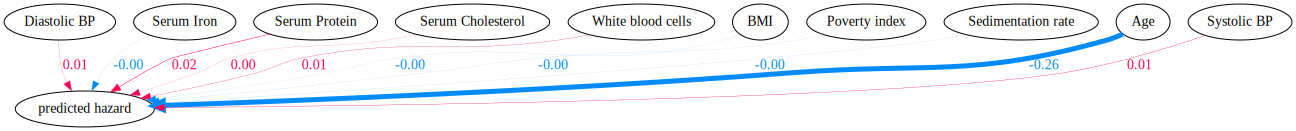

<AGraph <Swig Object of type 'Agraph_t *' at 0x7fb7e86c9a20>>

In [9]:
cf.draw(sample_ind, max_display=10, edge_credit=edge_credits2edge_credit(edge_credits, cf.graph), show_fg_val=False)

# On manifold SHAP

In [10]:
feature_names = X.columns
f = lambda x: model.predict(xgboost.DMatrix(pd.DataFrame(x, columns=feature_names)), output_margin=True) # wrapper for the model used by on manifold explainer
bg_on_manifold = X.fillna(X.mean()).sample(100) # used to learn conditional dependence

explainer = OnManifoldExplainer(f, bg_on_manifold, nruns=nruns, sigma_sq=1e-1, single_bg=False) # multiple sample version 
cf_on_manifold = explainer.shap_values(fg)

manifold bg samples: 100%|██████████| 100/100 [11:13<00:00,  6.74s/it]


On manifold


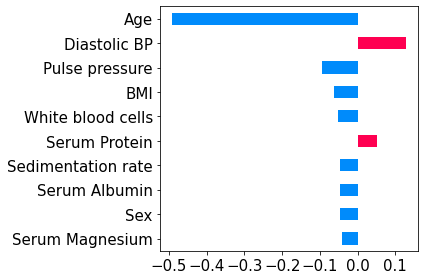

In [11]:
print('On manifold')
cf_on_manifold.draw(sample_ind, show=False, max_display=10)
plt.tight_layout()
plt.show()

# Shapley Flow

In [12]:
causal_links = CausalLinks()
categorical_feature_names = ['Race', 'Sex']
display_translator = translator(X.columns, X, X_display)
target_name = 'predicted hazard'
feature_names = list(X.columns)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_xgboost_f(feature_names, model, output_margin=True)) # the target uses log(HR) instead of HR
A = ['Diastolic BP', 'Systolic BP']
D = ['Pulse pressure'] # Systolic BP - Diastolic BP
causal_links.add_causes_effects(A, D, lambda dbp, sdp: sdp-dbp)
A = ['Age', 'Sex', 'Poverty index', 'Race']
D = list(set(feature_names) - set(A) - set(['Pulse pressure']))
causal_links.add_causes_effects(A, D)
A = ['Age', 'Sex', 'Race']
D = ['Poverty index']
causal_links.add_causes_effects(A, D)

causal_graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name)

learning dependency for Systolic BP:   0%|          | 0/14 [00:00<?, ?it/s]

[0]	test-rmse:136.18751
[100]	test-rmse:112.07594
[200]	test-rmse:92.46082
[300]	test-rmse:76.55484
[400]	test-rmse:63.71541
[499]	test-rmse:53.49734


learning dependency for White blood cells:   7%|▋         | 1/14 [00:00<00:07,  1.67it/s]

[0]	test-rmse:7.24529
[100]	test-rmse:6.04540
[200]	test-rmse:5.08526
[300]	test-rmse:4.32187
[400]	test-rmse:3.72444
[499]	test-rmse:3.26567


learning dependency for Serum Albumin:  14%|█▍        | 2/14 [00:01<00:07,  1.70it/s]    

[0]	test-rmse:3.87407
[100]	test-rmse:3.17810
[200]	test-rmse:2.60949
[300]	test-rmse:2.14547
[400]	test-rmse:1.76748
[499]	test-rmse:1.46278


learning dependency for TS:  21%|██▏       | 3/14 [00:01<00:06,  1.74it/s]           

[0]	test-rmse:29.79472
[100]	test-rmse:25.10775
[200]	test-rmse:21.40968
[300]	test-rmse:18.53344
[400]	test-rmse:16.33232
[499]	test-rmse:14.69491


learning dependency for TIBC:  29%|██▊       | 4/14 [00:02<00:05,  1.70it/s]

[0]	test-rmse:365.08758
[100]	test-rmse:300.40860
[200]	test-rmse:247.82375
[300]	test-rmse:205.21208
[400]	test-rmse:170.85916
[499]	test-rmse:143.55504


learning dependency for BMI:  36%|███▌      | 5/14 [00:02<00:05,  1.72it/s] 

[0]	test-rmse:25.68026
[100]	test-rmse:21.22700
[200]	test-rmse:17.61862
[300]	test-rmse:14.70853
[400]	test-rmse:12.38153
[499]	test-rmse:10.55001


learning dependency for Poverty index:  43%|████▎     | 6/14 [00:03<00:04,  1.69it/s]

[0]	test-rmse:365.16956
[100]	test-rmse:325.23489
[200]	test-rmse:295.42532
[300]	test-rmse:273.60980
[400]	test-rmse:257.95935
[499]	test-rmse:247.04846


learning dependency for Diastolic BP:  50%|█████     | 7/14 [00:04<00:04,  1.65it/s] 

[0]	test-rmse:83.71988
[100]	test-rmse:68.93323
[200]	test-rmse:56.90493
[300]	test-rmse:47.15287
[400]	test-rmse:39.27799
[499]	test-rmse:33.00833


learning dependency for Serum Protein:  57%|█████▋    | 8/14 [00:04<00:03,  1.67it/s]

[0]	test-rmse:6.61101
[100]	test-rmse:5.42027
[200]	test-rmse:4.44728
[300]	test-rmse:3.65282
[400]	test-rmse:3.00507
[499]	test-rmse:2.48216


learning dependency for Serum Cholesterol:  64%|██████▍   | 9/14 [00:05<00:02,  1.82it/s]

[0]	test-rmse:226.94263
[100]	test-rmse:187.87550
[200]	test-rmse:156.24817
[300]	test-rmse:130.78793
[400]	test-rmse:110.44482
[499]	test-rmse:94.44800


learning dependency for Sedimentation rate:  71%|███████▏  | 10/14 [00:05<00:02,  1.77it/s]

[0]	test-rmse:19.38453
[100]	test-rmse:16.95487
[200]	test-rmse:15.09857
[300]	test-rmse:13.70687
[400]	test-rmse:12.67748
[499]	test-rmse:11.94172


learning dependency for Serum Magnesium:  79%|███████▊  | 11/14 [00:06<00:01,  1.75it/s]   

[0]	test-rmse:1.18907
[100]	test-rmse:0.97714
[200]	test-rmse:0.80443
[300]	test-rmse:0.66402
[400]	test-rmse:0.55023
[499]	test-rmse:0.45920


learning dependency for Serum Iron:  86%|████████▌ | 12/14 [00:06<00:01,  1.81it/s]     

[0]	test-rmse:105.80270
[100]	test-rmse:88.86579
[200]	test-rmse:75.45215
[300]	test-rmse:64.97789
[400]	test-rmse:56.92674
[499]	test-rmse:50.90213


learning dependency for Red blood cells:  93%|█████████▎| 13/14 [00:07<00:00,  1.67it/s]

[0]	test-rmse:56.62017
[100]	test-rmse:47.20332
[200]	test-rmse:39.64856
[300]	test-rmse:33.63278
[400]	test-rmse:28.88807
[499]	test-rmse:25.23218


learning dependency for Red blood cells: 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]


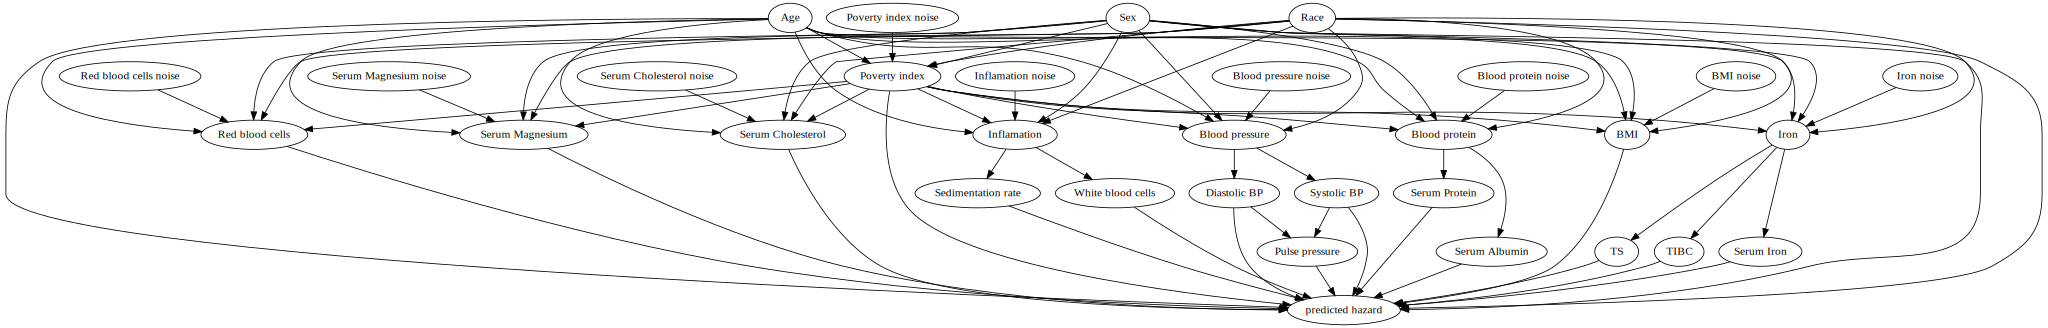

In [13]:
E = GraphExplainer(causal_graph, bg[:1])
E.prepare_graph(fg) # add noise node
G = copy.deepcopy(E.graph) # group happens after noise node b/c the grouped nodes combines individual noise node
G = group_nodes(G, [n for n in G if n.name in ['White blood cells', 'Sedimentation rate']], 'Inflamation')
G = group_nodes(G, [n for n in G if n.name in ['Systolic BP', 'Diastolic BP']], 'Blood pressure')
G = group_nodes(G, [n for n in G if n.name in ['TS', 'TIBC', 'Serum Iron']], 'Iron')
G = group_nodes(G, [n for n in G if n.name in ['Serum Protein', 'Serum Albumin']], 'Blood protein')
G.draw()

In [14]:
# multiple background result with individual run
causal_edge_credits = [] # save for each run
for i in range(len(bg)): # average run result using linearity axiom
    print(f'bg {i}/{len(bg)}')

    E = GraphExplainer(causal_graph, bg[i:i+1])
    E.prepare_graph(fg) # add noise node
    G = copy.deepcopy(E.graph) # group happens after noise node b/c the grouped nodes combines individual noise node
    G = group_nodes(G, [n for n in G if n.name in ['White blood cells', 'Sedimentation rate']], 'Inflamation')
    G = group_nodes(G, [n for n in G if n.name in ['Systolic BP', 'Diastolic BP']], 'Blood pressure')
    G = group_nodes(G, [n for n in G if n.name in ['TS', 'TIBC', 'Serum Iron']], 'Iron')
    G = group_nodes(G, [n for n in G if n.name in ['Serum Protein', 'Serum Albumin']], 'Blood protein')

    explainer = GraphExplainer(G, bg[i:i+1], nruns=nruns) 
    cf_c = explainer.shap_values(fg, skip_prepare=True)        
    causal_edge_credits.append(node_dict2str_dict(cf_c.edge_credit)) # use node name is more portable vs. node

bruteforce sampling:   0%|          | 0/100 [00:00<?, ?it/s]

bg 0/1


bruteforce sampling: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


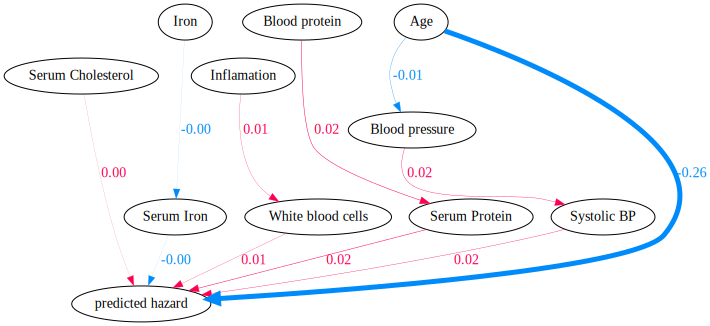

<AGraph <Swig Object of type 'Agraph_t *' at 0x7fb72c59e0f0>>

In [15]:
cf_c.draw(sample_ind, max_display=10, show_fg_val=False, edge_credit=edge_credits2edge_credit(causal_edge_credits, cf_c.graph))

# Methods comparison: flow, independent, on-manifold, ASV

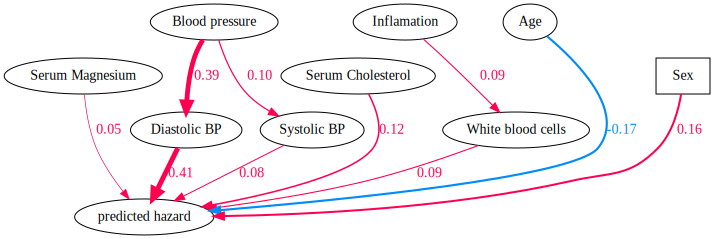

In [16]:
sample_ind = 66
cf_c.fold_noise = True
g = cf_c.draw(sample_ind, max_display=10, show_fg_val=False, edge_credit=edge_credits2edge_credit(causal_edge_credits, cf_c.graph))

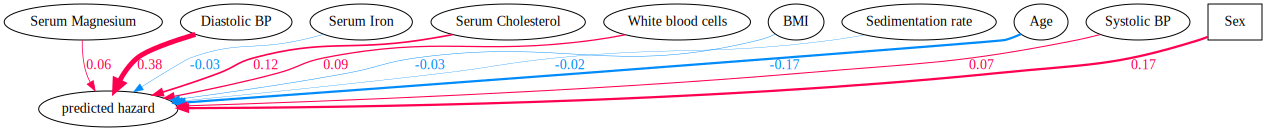

<AGraph <Swig Object of type 'Agraph_t *' at 0x7fb730821510>>

In [17]:
cf.draw(sample_ind, max_display=10, show_fg_val=False, edge_credit=edge_credits2edge_credit(edge_credits, cf.graph))

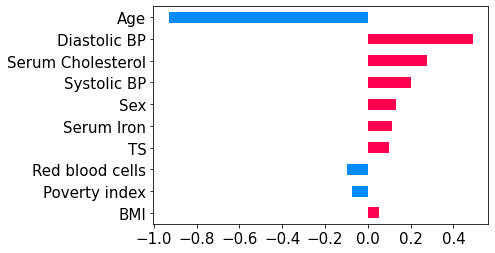

In [18]:
cf_on_manifold.draw(sample_ind, max_display=10)

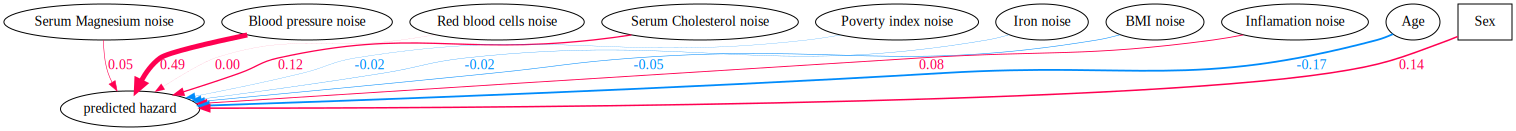

In [19]:
cf_c.fold_noise = False
g = cf_c.draw_asv(sample_ind, max_display=10, show_fg_val=False, flow_credit=edge_credits2edge_credit(causal_edge_credits, cf_c.graph))

Note that the attribution for Age is much different for on-manifold SHAP and other methods.

# Investigate the background and foreground samples

In [20]:
bg_sample = bg.iloc[0]
pd.concat([bg_sample, X_display.iloc[sample_ind]], 1).rename(columns={bg_sample.name: "background sample", sample_ind: 'foreground sample'}).T

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
background sample,46,78,187,1,46.7,24,4.3,202,46,1.63,7.2,2,108,371,12.4,5.4,21.3906,30
foreground sample,43,112,604,1,77.7,19,4.6,390,149,1.42,6.7,Male,154,443,33.6,17.9,30.7974,42


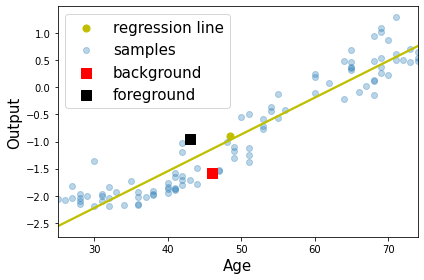

In [21]:
o = f(np.array(fg))

xlabel = 'Age'
ylabel = 'Output'

sns.regplot(fg[xlabel], o, x_bins=1, order=1, ci=None, label='regression line', color='y')
plt.scatter(fg[xlabel], o, alpha=0.3, label='samples')
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.scatter(bg[xlabel].iloc[[0]], f(np.array(bg))[[0]], c=['red'], s=100, marker='s', label='background')
plt.scatter(X[xlabel][[sample_ind]], o[[sample_ind]], c=['black'], s=100, marker='s', label='foreground')
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

Increasing the age, increases log hazard.

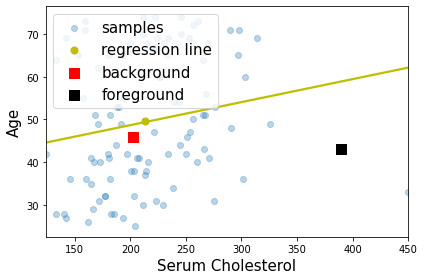

In [22]:
o = f(np.array(fg))

def normalize(o): # normalize to 0-1
    return (o - o.min()) / (o.max() - o.min())

ylabel = 'Age'
xlabel = 'Serum Cholesterol'

plt.scatter(fg[xlabel], fg[ylabel],
            alpha=0.3, label='samples')
sns.regplot(fg[xlabel], fg[ylabel], x_bins=1, order=1, ci=None, label='regression line', color='y')
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)

plt.scatter(bg[xlabel].iloc[[0]], bg[ylabel].iloc[[0]], c=['red'], s=100, marker='s', label='background')
plt.scatter(X[xlabel][[sample_ind]], X[ylabel][[sample_ind]], c=['black'], s=100, marker='s', label='foreground')
plt.legend(fontsize=15, loc="upper left")

plt.tight_layout()
# plt.savefig(f'figures/manifold_multiple_explain_age_{xlabel}_{sample_ind}.png')
plt.show()

Updating Systolic Cholesterol before Age would cause the expeted age to increase, thus making Age much more protective for this sample, which is confusing.